# Mod 3 Final Project

## Student Info

- Name: Andi Osika
- Cohort: ptds_100719
- Instructor: James Irving, PhD


# Introduction:

Access to a company database for Northwind Traders was provided to develop and test four hypotheses to provide business insight and appropriate recommendations.  The SQL database schema is provided below that outlines various tables which contain product, sales order, employee and customer information.  Upon reviewing the tables and data contained within them, it was determined to focus of this series of tests were around maximizing revenues.

The questions to be answered are listed below and the links lead to the series corresponding hypotheses testing. 

[Question 1 / Hypothesis 1](#HYPOTHESIS-1)
> **Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?** 

[Question 2 / Hypothesis 2](#HYPOTHESIS-2)
> **Do some categories statistically generate more revenue than others ?? Which ones?**

[Question 3 / Hypothesis 3](#HYPOTHESIS-3)
> ***Do certain sales representatives statistically sell more than others?  Who are the top sellers?***

[Question 4/ Hypotheisis 4](#HYPOTHESIS-4)
> ***Where are the customers from that spend the most money?  Do some regions generate statistically significantly more revenue than others?***

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-mod-3-project-online-ds-ft-100719/master/Northwind_ERD_updated.png">

In [241]:
# !pip install -U fsds_100719
# from fsds_100719.imports import *

import pandas as pd


In [122]:
import functions as fn

## Uncomment the line below to see the source code for the imported functions
# fs.ihelp(Cohen_d,False),fs.ihelp(find_outliers_IQR,False), fs.ihelp(find_outliers_Z,False)

In [123]:
import sqlite3
connect = sqlite3.connect('Northwind_small.sqlite')
cur = connect.cursor()

# List of Tables:

In [124]:
cur.execute("""SELECT name FROM sqlite_master WHERE type='table';""")
df_tables = pd.DataFrame(cur.fetchall(), columns=['Table'])
df_tables

,Table
0,Employee
1,Category
2,Customer
3,Shipper
4,Supplier
5,Order
6,Product
7,OrderDetail
8,CustomerCustomerDemo
9,CustomerDemographic


In [125]:
cur.execute("""SELECT * FROM `Order`;""")
df = pd.DataFrame(cur.fetchall(), columns=[x[0] for x in cur.description])
df.head()


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [126]:
## looking at dates to get an idea of timeframe
df['OrderDate']=pd.to_datetime(df['OrderDate'])

In [127]:
df['OrderDate'].describe()

count                     830
unique                    480
top       2014-02-26 00:00:00
freq                        6
first     2012-07-04 00:00:00
last      2014-05-06 00:00:00
Name: OrderDate, dtype: object

Timespan is ~ 2 years : April 7 2012 - June 5 2014

# HYPOTHESIS 1

> ***Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?***

- $H_0$:There is no statistcally significant effect on the quantity of a product in an order in relation to a discount amount.
- $H_1$:Discounts have a statistically significant effect on the quantiy of a product in an order.
- $H_1a$:Certain discount values have a greater effect than others.

## Importing and inspecting data from OrderDetail table:

This table from the Northwind database includes order information on:

    1) Quantity
    2) Discount 

Once imported, the data will be grouped by discount level and the means of the quantity sold for each will be compared against each other to evaluate if they are statistically significantly different.  This will determine if the null hypothesis can be rejected with a probability of 5% error in reporting a false negative.

In [128]:
cur.execute("""SELECT * FROM OrderDetail;""")
df = pd.DataFrame(cur.fetchall(), columns=[x[0] for x in cur.description])
df.head()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [129]:
#explorting dataset
specs = df.describe()
specs

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


General Observation: Pricing ranges from `$2` - `$263` with an average price of `$26.21` and average qty of 23 items ordered, no null values

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [131]:
len(df['OrderId'].unique())

830

### Initial Visual Inspection:

From this dataset of 2155 line items that span 830 orders, the average quantity ordered is 24 regardless of discount, the minimum ordered is 0 and max ordered is 130, although the IQR is between 10 and 30.

In [132]:
qty = df['Quantity']
qty_specs = qty.describe()
qty_specs

count    2155.000000
mean       23.812993
std        19.022047
min         1.000000
25%        10.000000
50%        20.000000
75%        30.000000
max       130.000000
Name: Quantity, dtype: float64

In [133]:
qty_mu = round(qty_specs['mean'],0)
n = len(df)
print(f'The average quantity ordered from this sample is : {qty_mu}')
print(f'There are {n} orders in this sample.')

The average quantity ordered from this sample is : 24.0
There are 2155 orders in this sample.


In [134]:
d =list(df['Discount'].unique())
d
#Dscounts are as follows:

[0.0, 0.15, 0.05, 0.2, 0.25, 0.1, 0.02, 0.03, 0.04, 0.06, 0.01]

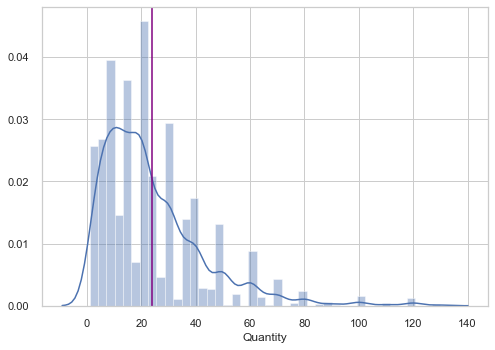

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(qty)
plt.axvline(qty_mu, label='Qty Mean', color='purple')
plt.show()


In [136]:
import seaborn as sns
from ipywidgets import interact

In [137]:

@interact
def plt_discounts(d=d):
    sns.distplot(df.groupby('Discount').get_group(d)['Quantity'])
    plt.axvline(qty_mu, color='purple')
    

interactive(children=(Dropdown(description='d', options=(0.0, 0.15, 0.05, 0.2, 0.25, 0.1, 0.02, 0.03, 0.04, 0.…

In [138]:
dfa = df.groupby('Discount').count()['Quantity']
display(dfa)


Discount
0.00    1317
0.01       1
0.02       2
0.03       3
0.04       1
0.05     185
0.06       1
0.10     173
0.15     157
0.20     161
0.25     154
Name: Quantity, dtype: int64

**The sample sizes associated with discounts .01, .02, .03, .04 and .06 are relatively nominal <4, and will be dropped as without a normal or comperable dataset to evaulate their impact in comparison with the other groups.**

In [139]:
discs = {}
for disc in df['Discount'].unique():
    discs[disc] = df.groupby('Discount').get_group(disc)['Quantity']

In [140]:
for k,v in discs.items():
    print(k)

0.0
0.15
0.05
0.2
0.25
0.1
0.02
0.03
0.04
0.06
0.01


In [141]:
l=[.01,.02,.03,.04,.06]
oneper = discs.pop(.01)
twoper = discs.pop(.02)
threeper = discs.pop(.03)
fourper = discs.pop(.04)
sixper = discs.pop(.06)

Distributions appear roughly equal,


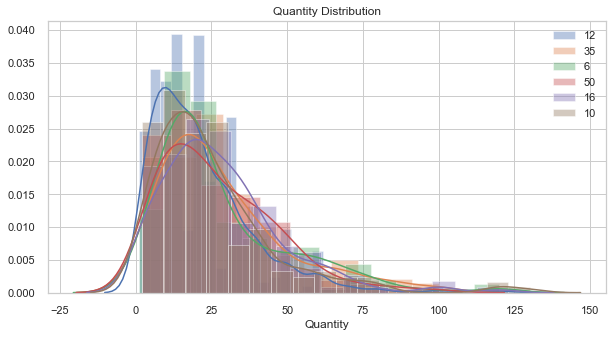

In [142]:
#visualizing distributions
fig, ax = plt.subplots(figsize=(10,5))
for k,v in discs.items():
    sns.distplot(v,label=v)

plt.title('Quantity Distribution')
plt.legend()
print('Distributions appear roughly equal,')

## Initial Observations:

Datatype is numeric.  

The average quantity ordered from this sample is : 24.0
There are 2155 orders in this sample. 

Discounts are as follows:
0.0, 0.15, 0.05, 0.2, 0.25, 0.1, 0.02, 0.03, 0.04, 0.06, 0.01

The majority of product purchases are without the discount(1317/2155) 61%, and frequency of discounts are as follows:
5%
10%
20%
15%
25%

For discounts 1%,2%,3%,4%, and 6% , the amount of data provided was relatively small to evaluate the impact on the whole.  This data was removed from further testing.

Overall distributions appears relatively uniform. 

### Since we are comparing multiple discounts to inspect it's impact on quantity ordered an AVNOVA or Kruksal test will be run depending on how assumptions are met: 
   
    
Assumptions for ANOVA Testing: 
(see corresponding sections

1) No significant outliers 
    * Upon a quick visual inspection, the distribution is skewed and visually there appears to be some outliers

2) Equal variance
    * Lavene's testing demonstrates NOT equal variance


3) Normality (if n>15)
      * Not required for discounts: 5%, 10%, 15%, 20% and 25% since n > 15




### Assumption 1:  Outliers 

Evaluation and removal via Z-Score testing:


In [143]:
for disc, disc_data in discs.items():
    idx_outs = fn.find_outliers_Z(disc_data)
    print(f'Found {idx_outs.sum()} outliers in Discount Group {disc}')
    discs[disc] = disc_data[~idx_outs]
print('\n All of these outliers were removed')

Found 20 outliers in Discount Group 0.0
Found 2 outliers in Discount Group 0.15
Found 3 outliers in Discount Group 0.05
Found 2 outliers in Discount Group 0.2
Found 3 outliers in Discount Group 0.25
Found 3 outliers in Discount Group 0.1

 All of these outliers were removed


### Assumption 2: Equal Variance

Levines testing conducted on cleaned dataset


In [144]:
#preparing data for levene's testing
datad = []
for k,v in discs.items():
    datad.append(v)

In [145]:
import scipy.stats as stats
stat,p = stats.levene(discs[0.0],discs[0.05],discs[0.1],discs[0.25], discs[0.15], discs[0.20])
print(f'Lavene test for equal variance results are {round(p,4)}')
sig = 'do NOT' if p < .05 else 'DO'

print(f'The groups {sig} have equal variance')


Lavene test for equal variance results are 0.0003
The groups do NOT have equal variance


#### Since group does not prove to be equal variance, a **kruksal** will be conducted.
Looking at sample sizes to determine if normality needs to be tested.

### Assumption 3: Normality

First, checking sample sizes since assumption for normality depends on sample size. If 2-9 groups, each group n >= 15

For Discounts of 5%, 10%, 15%, 20% and 25% n>15 

In [146]:
n = []
for disc, disc_data in discs.items():
    print(f'There are {len(disc_data)} samples in the {disc} discount group.')    
    n.append(len(disc_data)>15)
if all(n):
    print('\nAll samples are >15: Normality Assumption Criterion is met.')


There are 1297 samples in the 0.0 discount group.
There are 155 samples in the 0.15 discount group.
There are 182 samples in the 0.05 discount group.
There are 159 samples in the 0.2 discount group.
There are 151 samples in the 0.25 discount group.
There are 170 samples in the 0.1 discount group.

All samples are >15: Normality Assumption Criterion is met.


## Kruksal Testing:

In [147]:
stat, p = stats.kruskal(discs[0.0],discs[0.05],discs[0.1],discs[0.25], discs[0.15], discs[0.20])
print(f"Kruskal test p value: {round(p,4)}")
if p < .05 :
    print(f'Reject the null hypothesis')
else: 
    print(f'Null hypotheis remains true')
    

Kruskal test p value: 0.0
Reject the null hypothesis


#### ANOVA Testing for comparison

In [148]:
stat, p = stats.f_oneway(*datad)
print(f"ANOVA test p value: {round(p,4)}")
if p < .05 :
    print(f'Reject the null hypothesis')
else: 
    print(f'Null hypotheis remains true')


ANOVA test p value: 0.0
Reject the null hypothesis


### Post-Hoc Testing: 

In [149]:
disc_df = fn.prep_data_for_tukeys(discs)
disc_df

,data,group
0,12.0,0.0
1,10.0,0.0
2,5.0,0.0
3,9.0,0.0
4,40.0,0.0
...,...,...
2095,30.0,0.1
2096,77.0,0.1
2098,25.0,0.1
2099,4.0,0.1


In [150]:
disc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2114 entries, 0 to 2135
Data columns (total 2 columns):
data     2114 non-null float64
group    2114 non-null object
dtypes: float64(1), object(1)
memory usage: 49.5+ KB


In [151]:
d =list(disc_df['group'].unique())
d

['0.0', '0.15', '0.05', '0.2', '0.25', '0.1']

In [152]:
import statsmodels.api as sms
tukey = sms.stats.multicomp.pairwise_tukeyhsd(disc_df['data'],disc_df['group'])
tukey.summary()



group1,group2,meandiff,p-adj,lower,upper,reject
0.0,0.05,6.0639,0.001,2.4368,9.691,True
0.0,0.1,2.9654,0.2098,-0.7723,6.7031,False
0.0,0.15,6.9176,0.001,3.0233,10.8119,True
0.0,0.2,5.6293,0.001,1.7791,9.4796,True
0.0,0.25,6.1416,0.001,2.2016,10.0817,True
0.05,0.1,-3.0985,0.4621,-7.9861,1.789,False
0.05,0.15,0.8537,0.9,-4.1547,5.862,False
0.05,0.2,-0.4346,0.9,-5.4088,4.5396,False
0.05,0.25,0.0777,0.9,-4.9663,5.1218,False
0.1,0.15,3.9522,0.2311,-1.1368,9.0412,False


There is a statistically significant effect on quantity purchased based on discount. The discounts below are statistically considered equal:



In [153]:
disc_tukey = fn.tukey_df(tukey)
disc_tukey_trues = disc_tukey.loc[disc_tukey['reject']==True]
disc_tukey_trues

,group1,group2,meandiff,p-adj,lower,upper,reject
0,0.0,0.05,6.0639,0.001,2.4368,9.6910,True
2,0.0,0.15,6.9176,0.001,3.0233,10.8119,True
3,0.0,0.2,5.6293,0.001,1.7791,9.4796,True
4,0.0,0.25,6.1416,0.001,2.2016,10.0817,True


In [154]:
disc_df['group']=disc_df['group'].astype(str)
d=disc_df['group']

In [155]:

@interact
def plt_discounts(d=d):
    sns.distplot(disc_df.groupby('group').get_group(d)['data'])
    plt.axvline(qty_mu, color='purple')
    

interactive(children=(Dropdown(description='d', options=('0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0…

In [156]:
stats = disc_df['data'].describe()
dataqty = stats['mean']
print(f'Revised average quantity sold across all orders {round(dataqty)}')
zeros = disc_df.groupby('group').get_group('0.0')['data']
nodiscav = zeros.mean()
print(f'Average quantity sold for orders where no discount was extended was: {round(nodiscav)}')

Revised average quantity sold across all orders 23.0
Average quantity sold for orders where no discount was extended was: 21.0


In [157]:
for k,v in discs.items():
    print(f'The average quantity sold for {k} discount is {round(v.mean())}')

The average quantity sold for 0.0 discount is 21.0
The average quantity sold for 0.15 discount is 27.0
The average quantity sold for 0.05 discount is 27.0
The average quantity sold for 0.2 discount is 26.0
The average quantity sold for 0.25 discount is 27.0
The average quantity sold for 0.1 discount is 24.0


In [158]:
data_mu = disc_df['data'].mean()
print(f'The average qty purchased regardless of discount or none offered is {round(data_mu)}')

The average qty purchased regardless of discount or none offered is 23.0


### Various EDA to understand distributions and remaining potential outliers

The following hex-bin visualization illustrates the density of data in the 0% category. Visually, this appears that equal quantitites are purchased, but might be due to light markings relative to sample sizes.  Clearly not the best choice for EDA, and further exploration is required.

Text(336.9714285714286, 0.5, 'Qty')

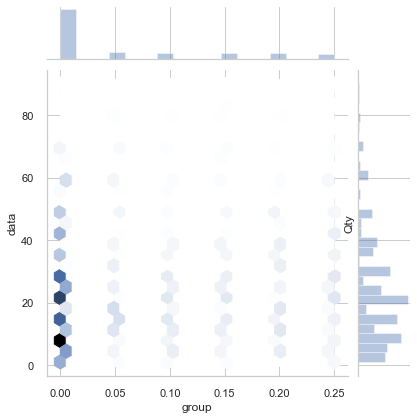

In [159]:
disc_df['group'] = disc_df['group'].astype(float)
sns.jointplot(data=disc_df, x='group', y='data', kind='hex')
plt.ylabel('Qty')

Visual on distributions and potential remaining outliers:

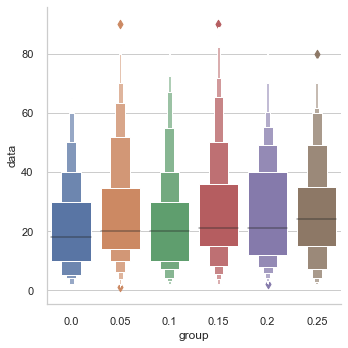

In [160]:
#boxen plot
sns.catplot(data=disc_df, x='group', y='data', kind='boxen')
ax.axhline(26.75, color='k')
plt.gca()
plt.show()

This plot may not best suit non-technical audience with the additional information potentially could cause confusion.  However, the above boxen plot clearly illustrates distributions as well as remaining potential outliers in the .05, .15, .2 and .25 groups.  These outliers will not be removed at the present moment with the intention to preserve as much of the initial dataset as possible.  Sample sizes can be referenced under 'Assumption 3: Normality' where this is observed.

Text(0, 0.5, 'Average Quantity Purchased')

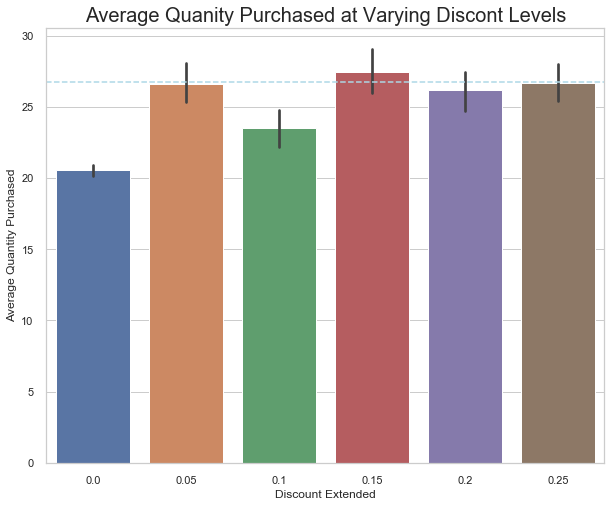

In [161]:
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=disc_df, x='group', y='data', ci=68)
#plt.axhline(data_mu, linestyle='--', color='darkgray')
plt.axhline(26.75, linestyle='--', color='lightblue')
plt.title('Average Quanity Purchased at Varying Discont Levels', fontsize=20)
plt.xlabel('Discount Extended')
plt.ylabel('Average Quantity Purchased')

Effect Sizes: 

In [162]:
for disc, disc_data in discs.items():
    es = fn.Cohen_d(zeros, disc_data)
    print(f'The effect size for {disc} is {round(np.abs(es),4)}')

The effect size for 0.0 is 0.0
The effect size for 0.15 is 0.453
The effect size for 0.05 is 0.3949
The effect size for 0.2 is 0.3751
The effect size for 0.25 is 0.4109
The effect size for 0.1 is 0.1982


## Hypothesis 1 Findings and Recommendation:

### Findings:
**Rejecting the null hypothesis :**
*   𝐻0 :There is no statistcally significant effect on the quantity of a product in an order in relation to a discount amount.


**Alternative hypothesese:**

    *  𝐻1 :Discounts have a statistically significant effect on the quantiy of a product in an order.
    *  𝐻1𝑎 :Certain discount values have a greater effect than others.(see below for findings)

A 10% discount had no statistical significance on the quantiy purchased.

Discounts extended at 5%, 15%, 20%, and 25% statistically are equal in terms of their effect on quantity sold when compared to none offered, with a p-value of .001 meaning there is a .01 percent chance of classifying them as such due to chance. Each have varying effect sizes in compared to orders placed with no discount extended.
 
Discount |AvQty | Effect Size | Effect
 -- | -- | -- | --|
5 % | 27| .1982 | Small
15 % | 27| .454 | Medium
20 % |26| .3751 | Medium
25 % |27 | .454 | Medium

Additional notes:
For discounts 1%,2%,3%,4%, and 6% that were included in the original dataset, the amount of data provided was relatively small to evaluate the impact on the whole. This data was removed from further testing

With additional outliers removed for each of the discount groups, the revised average qty purchased was 23 overall.


 
###  Recommendation:

While larger discounts did deomonstrate significant effect on quantity purchased, smaller discounts held a statistically equal effect.  To recognize the effect of driving higher quantities purchased and realize larger profit margins, offer the smaller discount.


# HYPOTHESIS 2

> ***Do some categories statistically generate more revenue than others ?? Which ones?***
 
 


- $𝐻0$ : All categories generate equal revenues.
- $𝐻1$ : Certain categories sell at statistically higher rates of revneu than others.
- $𝐻1𝑎$ : 

### Importing and inspecting data from Product and OrderDetail tables:

These tables includes product information data including:

1) Categories 

2) Pricing and discount information to generate revenues


In [163]:
##clean sql notation
cur.execute("""SELECT 
                ProductId, 
                ProductName, 
                od.UnitPrice,
                CategoryID, 
                CategoryName, 
                Discount, 
                Quantity
                FROM Product AS p
                JOIN OrderDetail as od
                ON p.ID = Od.ProductId
                JOIN Category as c 
                ON c.ID = p.CategoryID;""")
catavs = pd.DataFrame(cur.fetchall(), columns=[x[0] for x in cur.description])
catavs.head()

,ProductId,ProductName,UnitPrice,CategoryId,CategoryName,Discount,Quantity
0,11,Queso Cabrales,14.0,4,Dairy Products,0.0,12
1,42,Singaporean Hokkien Fried Mee,9.8,5,Grains/Cereals,0.0,10
2,72,Mozzarella di Giovanni,34.8,4,Dairy Products,0.0,5
3,14,Tofu,18.6,7,Produce,0.0,9
4,51,Manjimup Dried Apples,42.4,7,Produce,0.0,40


In [164]:
#Revenue is calculated by subtracting discounts from the UnitPrice and multiplying by quantity ordered.
catavs['Revenue'] = (catavs['UnitPrice'] * (1 - catavs['Discount']))*catavs['Quantity']

In [165]:
avcrev = catavs['Revenue'].mean()
print (round(avcrev),2)
cg = catavs['CategoryName'].unique()




587.0 2


### Initial Visual Inspection and Observations:

There are 8 different categories sold in this company that represent 77 products.

The average revenue generated across all categories is `$587.00`

Visually, it appears that there are three categories that significantly generate higher revenues than others, additional testing will demonstrate their siginficance and effect.


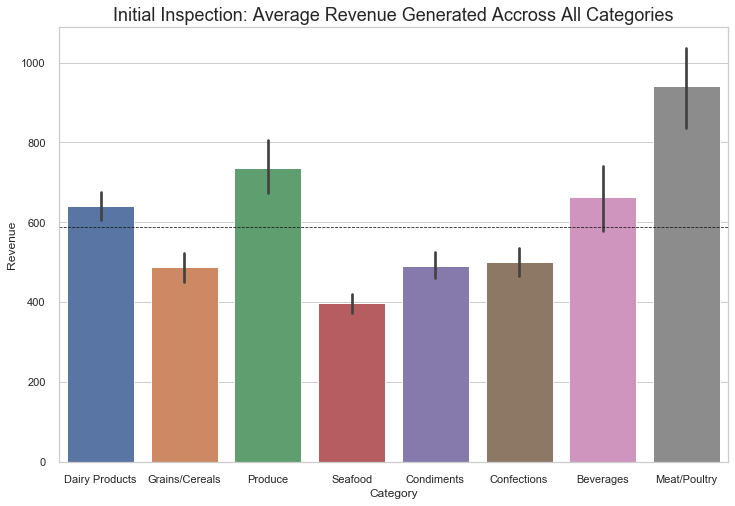

In [166]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=catavs, x='CategoryName', y='Revenue', ci=68, ax=ax)
plt.title('Initial Inspection: Average Revenue Generated Accross All Categories', fontsize=18)
plt.axhline(avcrev,linestyle="--", color='k', linewidth=.8 )
plt.xlabel('Category')
plt.ylabel('Revenue')
plt.show()

In [167]:
catcount = len(catavs['CategoryId'].unique())
avrev = catavs['Revenue'].mean()
print(f'There are {catcount} different categories sold in this company')
print(f'The average revenue generated accross all categories is {round(avcrev,0)}')

There are 8 different categories sold in this company
The average revenue generated accross all categories is 587.0


In [168]:
cats = {}
for cat in catavs['CategoryName'].unique():
    cats[cat] = catavs.groupby('CategoryName').get_group(cat)['Revenue']

In each of the different categories, the products align as such: 

In [169]:
catsprods = {}
for cat in catavs['CategoryName'].unique():
    catsprods[cat] = catavs.groupby('CategoryName').get_group(cat)['ProductId'].unique()

In [170]:
for k,v in catsprods.items():
    print(f'There are {len(v)} products in the {k} Category')


There are 10 products in the Dairy Products Category
There are 7 products in the Grains/Cereals Category
There are 5 products in the Produce Category
There are 12 products in the Seafood Category
There are 12 products in the Condiments Category
There are 13 products in the Confections Category
There are 12 products in the Beverages Category
There are 6 products in the Meat/Poultry Category


### Assumption 1: Outliers
Outliers removed via z-score testing.

In [171]:
for cat, cat_data in cats.items():
    idx_outs = fn.find_outliers_Z(cat_data)
    print(f'Found {idx_outs.sum()} outliers in Category # {cat}')
    cats[cat] = cat_data[~idx_outs]
print('\n All of these outliers were removed')

Found 5 outliers in Category # Dairy Products
Found 6 outliers in Category # Grains/Cereals
Found 1 outliers in Category # Produce
Found 8 outliers in Category # Seafood
Found 4 outliers in Category # Condiments
Found 9 outliers in Category # Confections
Found 12 outliers in Category # Beverages
Found 4 outliers in Category # Meat/Poultry

 All of these outliers were removed


In [172]:
pids = catavs['ProductName'].unique()
pids
print(f'There are {len(pids)} products')

There are 77 products


### Assumption 2: Equal Variance

Testing cleaned dataset for equal variance.

Since the groups do NOT have euqal variance, a Kruksal test will be conducted.

In [173]:
datac = []
for k,v in cats.items():
    datac.append(v)

In [174]:
import scipy.stats as stats
stat,p = stats.levene(*datac)
print(f'Lavene test for equal variance results are {round(p,4)}')
sig = 'do NOT' if p < .05 else 'DO'

print(f'The groups {sig} have equal variance')

Lavene test for equal variance results are 0.0
The groups do NOT have equal variance


### Assumption 3: Normality

All groups are > 15 samples = Assumption for normality is met.

In [175]:
n = []

for cat, cat_data in cats.items():
    print(f'There are {len(cat_data)} samples in the data set for Employee #{cat}.')
    n.append(len(cat_data)>15)
if all(n):
    print('\nAll samples are >15: Normality Assumption Criterion is met.')




There are 361 samples in the data set for Employee #Dairy Products.
There are 190 samples in the data set for Employee #Grains/Cereals.
There are 135 samples in the data set for Employee #Produce.
There are 322 samples in the data set for Employee #Seafood.
There are 212 samples in the data set for Employee #Condiments.
There are 325 samples in the data set for Employee #Confections.
There are 392 samples in the data set for Employee #Beverages.
There are 169 samples in the data set for Employee #Meat/Poultry.

All samples are >15: Normality Assumption Criterion is met.


### Kruksal Testing:

Results, reject the null hypothesis.

In [176]:
stat, p = stats.kruskal(*datac)
print(f"Kruskal test p value: {round(p,4)}")
if p < .05 :
    print(f'Reject the null hypothesis')
else: 
    print(f'Null hypotheis remains true')

Kruskal test p value: 0.0
Reject the null hypothesis


### Post-Hoc Testing: 

In [177]:
cat_df = fn.prep_data_for_tukeys(cats)
cat_df

,data,group
0,168.00,Dairy Products
2,174.00,Dairy Products
12,47.50,Dairy Products
13,1088.00,Dairy Products
14,200.00,Dairy Products
...,...,...
2096,2702.70,Meat/Poultry
2098,738.00,Meat/Poultry
2099,86.40,Meat/Poultry
2102,111.75,Meat/Poultry


#### Visual Inspection Post Data Cleaning:

In [178]:

@interact
def plt_discounts(d=cg):
    sns.distplot(cat_df.groupby('group').get_group(d)['data'])
    plt.axvline(cat_df['data'].mean(), color='purple')
    plt.title('Average Revenue Generated by Category')
    plt.ylabel('Distribution')

interactive(children=(Dropdown(description='d', options=('Dairy Products', 'Grains/Cereals', 'Produce', 'Seafo…

In [179]:
tukeyc = sms.stats.multicomp.pairwise_tukeyhsd(cat_df['data'],cat_df['group'])
tukeyc.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Beverages,Condiments,55.7712,0.9,-78.858,190.4005,False
Beverages,Confections,27.0669,0.9,-91.4026,145.5364,False
Beverages,Dairy Products,194.0913,0.001,78.8965,309.286,True
Beverages,Grains/Cereals,21.4034,0.9,-118.1928,160.9996,False
Beverages,Meat/Poultry,411.042,0.001,265.7215,556.3625,True
Beverages,Produce,296.1055,0.001,138.516,453.695,True
Beverages,Seafood,-46.1557,0.9,-164.9266,72.6151,False
Condiments,Confections,-28.7043,0.9,-168.1193,110.7106,False
Condiments,Dairy Products,138.32,0.0449,1.6769,274.9631,True
Condiments,Grains/Cereals,-34.3678,0.9,-192.129,123.3933,False


In [180]:
for cat, cat_data in cats.items():
    print(f'The average revenue for {cat} is ${round(cat_data.mean(),2)}')

The average revenue for Dairy Products is $593.86
The average revenue for Grains/Cereals is $421.17
The average revenue for Produce is $695.87
The average revenue for Seafood is $353.61
The average revenue for Condiments is $455.54
The average revenue for Confections is $426.83
The average revenue for Beverages is $399.77
The average revenue for Meat/Poultry is $810.81


### Hypothesis 2: A Clean Vizualization

In [181]:
#help(cat_df.groupby('group').mean().sort_values('data').plot)

In [182]:
index = list(cat_df.groupby('group').mean().sort_values('data', ascending=False).index)
index

['Meat/Poultry',
 'Produce',
 'Dairy Products',
 'Condiments',
 'Confections',
 'Grains/Cereals',
 'Beverages',
 'Seafood']

Text(0.5, 1.0, 'Average Revenue* Generated By Category')

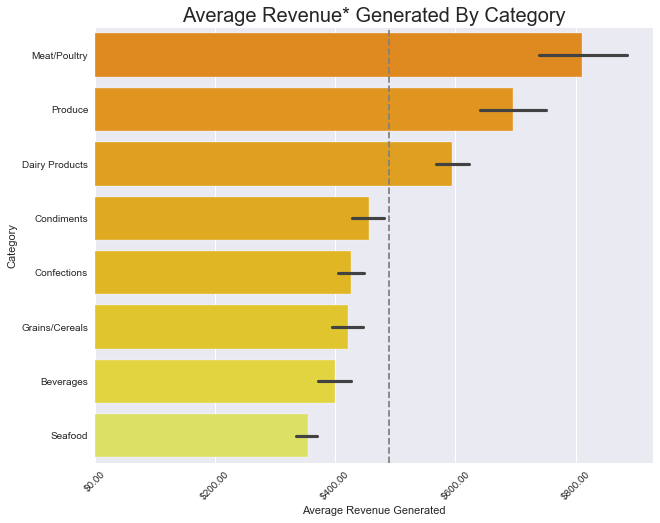

In [183]:
import matplotlib.ticker as ticker
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=cat_df, x=round(cat_df['data']), y=cat_df['group'],order=index, ci=68, palette='Wistia_r')
formatter = ticker.FormatStrFormatter('$%1.2f')
ax.xaxis.set_major_formatter(formatter)
plt.axvline(cat_df['data'].mean(), linestyle='--', color='gray')
plt.ylabel('Category')
plt.xlabel('Average Revenue Generated')
plt.xticks(rotation=45)
plt.title('Average Revenue* Generated By Category', fontsize=20)

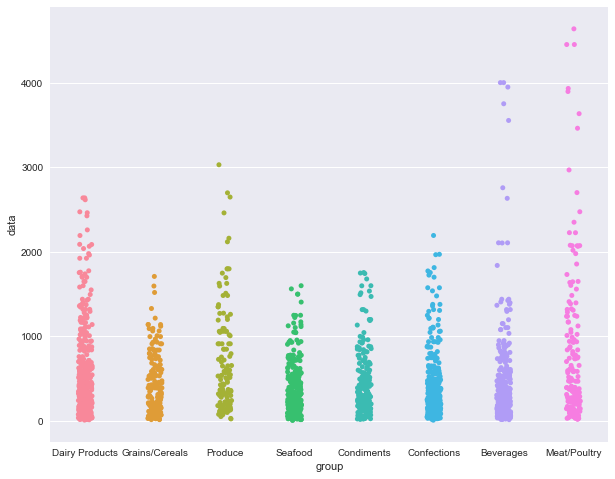

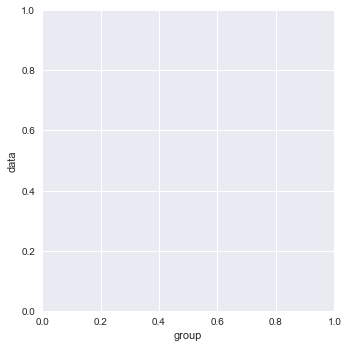

In [184]:
f, ax = plt.subplots(figsize=(10,8))
#sns.despine(f, left=True, bottom=True)
sns.catplot(data=cat_df, x='group', y='data', ax=ax)


In [185]:
tukeycdf = fn.tukey_df(tukeyc)

The following groups are statistically similar and accept the null hypothesis that all categories generate equal revenue:

In [186]:
tukeycfalse  = tukeycdf.loc[tukeycdf['reject']==False]
tukeycfalse

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Beverages,Condiments,55.7712,0.9000,-78.8580,190.4005,False
1,Beverages,Confections,27.0669,0.9000,-91.4026,145.5364,False
3,Beverages,Grains/Cereals,21.4034,0.9000,-118.1928,160.9996,False
6,Beverages,Seafood,-46.1557,0.9000,-164.9266,72.6151,False
7,Condiments,Confections,-28.7043,0.9000,-168.1193,110.7106,False
9,Condiments,Grains/Cereals,-34.3678,0.9000,-192.1290,123.3933,False
12,Condiments,Seafood,-101.9270,0.3439,-241.5981,37.7441,False
14,Confections,Grains/Cereals,-5.6635,0.9000,-149.8807,138.5537,False
17,Confections,Seafood,-73.2226,0.6099,-197.3920,50.9467,False
20,Dairy Products,Produce,102.0142,0.5181,-57.2991,261.3276,False


The folowing groups can reject the null hypothesis:

In [187]:
tukeyctrues  = tukeycdf.loc[tukeycdf['reject']==True]
tukeyctrues

,group1,group2,meandiff,p-adj,lower,upper,reject
2,Beverages,Dairy Products,194.0913,0.0010,78.8965,309.2860,True
4,Beverages,Meat/Poultry,411.0420,0.0010,265.7215,556.3625,True
5,Beverages,Produce,296.1055,0.0010,138.5160,453.6950,True
8,Condiments,Dairy Products,138.3200,0.0449,1.6769,274.9631,True
10,Condiments,Meat/Poultry,355.2707,0.0010,192.4225,518.1190,True
11,Condiments,Produce,240.3342,0.0010,66.4494,414.2191,True
13,Confections,Dairy Products,167.0244,0.0010,46.2712,287.7776,True
15,Confections,Meat/Poultry,383.9751,0.0010,234.2101,533.7401,True
16,Confections,Produce,269.0386,0.0010,107.3415,430.7357,True
18,Dairy Products,Grains/Cereals,-172.6879,0.0054,-314.2272,-31.1485,True


In [188]:
def mult_Cohn_d(tukey_result_df, df_dict):
    '''Using a dataframe from Tukey Test Results and a 
    corresponding dictionary, this function loops through 
    each variable and returns the adjusted p-value and Cohn_d test'''
    import pandas as pd
    
    res = [['g1', 'g2','padj', 'd']]
    for i, row in tukey_result_df.iterrows():
        g1 = row['group1']
        g2 = row['group2']
        padj = row['p-adj']
        d = fn.Cohen_d(df_dict[g1], df_dict[g2])

        res.append([g1, g2,padj, d])

    mdc = pd.DataFrame(res[1:], columns=res[0])
    return mdc

The table below illustrates those categories that can reject the null hypothesis that states all categories generate equal revenue.  The padj is the probability this is due to chance and the d column shows the effect size. 

In [189]:
mult_Cohn_d(tukeyctrues, cats)

,g1,g2,padj,d
0,Beverages,Dairy Products,0.0010,-0.351635
1,Beverages,Meat/Poultry,0.0010,-0.596175
2,Beverages,Produce,0.0010,-0.520603
3,Condiments,Dairy Products,0.0449,-0.277491
4,Condiments,Meat/Poultry,0.0010,-0.517399
5,Condiments,Produce,0.0010,-0.490099
6,Confections,Dairy Products,0.0010,-0.340630
7,Confections,Meat/Poultry,0.0010,-0.600173
8,Confections,Produce,0.0010,-0.560435
9,Dairy Products,Grains/Cereals,0.0054,0.349940


### Hypothesis 2 Findings and Recommendation:

#### Findings:

***Reject the null hypothesis:***
* 𝐻0  : All categories generate equal revenues.

***Alternative hypotheis***
* 𝐻1  : Certain categories sell at statistically higher rates of revnue than others.

Top three revenue-generating categories: Meat/Poultry, Produce, and Dairy Products.

Statistically, Meat/Poultry & Produce were statistically equivalent and ranked as top sellers, Dairy & Produce were statiscally equal. 
(Definition of statistically equal: they returned false value from Tukey test, indicating they had a simliar mean and therefore statiticaly equal with a .05 chance of falsely being classified as such)


 
 
Category | Average Revenue
-- | -- |
Meat/Poultry | `$810.81`
Produce | `$695.87`
Dairy Products | `$593.86`
Condiments | `$455.54`
Confections | `$426.83`
Grains/Cereals | `$421.17``
Beverages | `$399.77`
Seafood | `$353.61`

The table(s) above outlines how the various categories compare to each other.  If the adjusted p-value in column padj is >.05, they are statistically equal.  Conversely of the adjusted p-value 'adjp' is <.05 the two samples are statistically not-equal.  This is further examined by the effect size illustrated in column d.   d=0.2 be considered a 'small' effect size, 0.5 represents a 'medium' effect size and 0.8 a 'large' effect size. 

Notes:
Revenue is calculated by subtracting any extended discounts from the salesprice and multiplying that by quantity sold.


#### Recommendation: 

If there are additional products that align with the higher revenue generating categories, that category could be broadened to maximize revenue generating potential.  

Example: Meat/Poultry currently has 6 products, this could be expanded.  Conversely, the seafood category carries 12 products which could be narrowed.  Additional analysis could demonstrate which seafood are the best sellers which would be preserved.

Knowing what revenue each category generates could potentially influence the ability to appropriately categorize discounts.  However, not knowing profit margins - we'd need to take this into consideration.






# HYPOTHESIS 3

> ***Do certain sales representatives statistically sell more than others? Who are the top sellers?***

$H0$: All sales representatives generate equal revenue.

$H1$: Some sales representatives generate more than others in revenue.

### Importing and inspecting data from Product, OrderDetail, Order and Employee Tables
These table includes information on:

    1) Product information including SalesPrice, Discount and Quantity Sold
    2) Sales Representative Information

In [190]:
cur.execute("""SELECT 
                ProductID, 
                ProductName, 
                Discontinued,
                OrderID, 
                ProductID, 
                od.UnitPrice AS SalesPrice, 
                Quantity, 
                Discount,
                EmployeeID, 
                LastName, 
                FirstName, 
                e.Region, 
                ShippedDate
                FROM Product AS p
                JOIN OrderDetail AS od
                ON od.ProductID = p.Id 
                JOIN 'Order' AS o
                ON o.Id = od.OrderId
                JOIN Employee AS e
                ON o.EmployeeID = e.ID;""")
dfr = pd.DataFrame(cur.fetchall(), columns=[x[0] for x in cur.description])
dfr

,ProductId,ProductName,Discontinued,OrderId,ProductId,SalesPrice,Quantity,Discount,EmployeeId,LastName,FirstName,Region,ShippedDate
0,11,Queso Cabrales,0,10248,11,14.00,12,0.00,5,Buchanan,Steven,British Isles,2012-07-16
1,42,Singaporean Hokkien Fried Mee,1,10248,42,9.80,10,0.00,5,Buchanan,Steven,British Isles,2012-07-16
2,72,Mozzarella di Giovanni,0,10248,72,34.80,5,0.00,5,Buchanan,Steven,British Isles,2012-07-16
3,14,Tofu,0,10249,14,18.60,9,0.00,6,Suyama,Michael,British Isles,2012-07-10
4,51,Manjimup Dried Apples,0,10249,51,42.40,40,0.00,6,Suyama,Michael,British Isles,2012-07-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150,64,Wimmers gute Semmelknödel,0,11077,64,33.25,2,0.03,1,Davolio,Nancy,North America,None
2151,66,Louisiana Hot Spiced Okra,0,11077,66,17.00,1,0.00,1,Davolio,Nancy,North America,None
2152,73,Röd Kaviar,0,11077,73,15.00,2,0.01,1,Davolio,Nancy,North America,None
2153,75,Rhönbräu Klosterbier,0,11077,75,7.75,4,0.00,1,Davolio,Nancy,North America,None


In [191]:


#Sales Revenue is calculated by multiplying the adjusted price (accounting for any discounts) times quantity
dfr['SaleRev'] = (dfr['SalesPrice'] * (1-dfr['Discount'])) * dfr['Quantity']


In [192]:
empcount = len(dfr['EmployeeId'].unique())
avrev = dfr['SaleRev'].mean()
print(f'There are {empcount} employees in this company associated with sales information')
print(f'The calculated avarage revenue generated by a sales representative in this dataset is ${round(avrev)}')

There are 9 employees in this company associated with sales information
The calculated avarage revenue generated by a sales representative in this dataset is $587.0


### Hypothesis 3 Preliminary Visualizations:

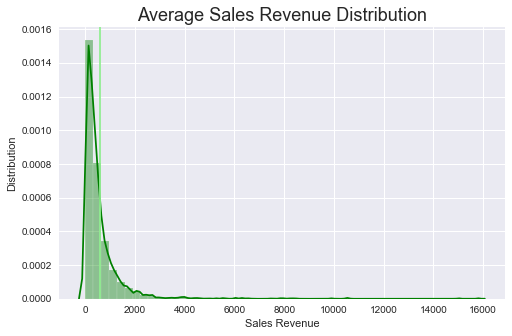

In [193]:
fig, ax = plt.subplots(figsize=(8,5))
sns.distplot(dfr['SaleRev'], color='green')
plt.axvline(avrev, color='lightgreen' )
plt.xlabel('Sales Revenue')
plt.ylabel('Distribution')
plt.title('Average Sales Revenue Distribution', fontsize=18)
plt.show()

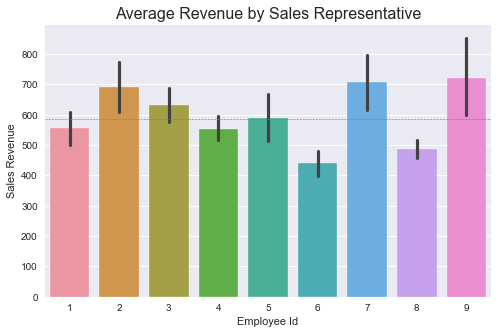

In [194]:
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(data=dfr, x='EmployeeId', y='SaleRev', ci=68, ax=ax)
plt.title('Average Revenue by Sales Representative', fontsize=16)
plt.axhline(avrev,linestyle="--", color='gray', linewidth=.6 )
plt.xlabel('Employee Id')
plt.ylabel('Sales Revenue')
plt.show()


Employees are listed in the table below:
Although the employee names are unique, for the sake of data inspection we'll continue to use Employee Id as the unique identifier and reference the table above to gather additional insight.

In [195]:
cur.execute("""SELECT ID, LastName, FirstName, Title, Region
                from Employee""")
empsdata = pd.DataFrame(cur.fetchall(), columns=[x[0] for x in cur.description])
empsdata

,Id,LastName,FirstName,Title,Region
0,1,Davolio,Nancy,Sales Representative,North America
1,2,Fuller,Andrew,"Vice President, Sales",North America
2,3,Leverling,Janet,Sales Representative,North America
3,4,Peacock,Margaret,Sales Representative,North America
4,5,Buchanan,Steven,Sales Manager,British Isles
5,6,Suyama,Michael,Sales Representative,British Isles
6,7,King,Robert,Sales Representative,British Isles
7,8,Callahan,Laura,Inside Sales Coordinator,North America
8,9,Dodsworth,Anne,Sales Representative,British Isles


In [196]:
reps = {}
for rep in dfr['EmployeeId'].unique():
    reps[str(rep)] = dfr.groupby('EmployeeId').get_group(rep)['SaleRev']


Distributions appear roughly equal and there appears to be outliers


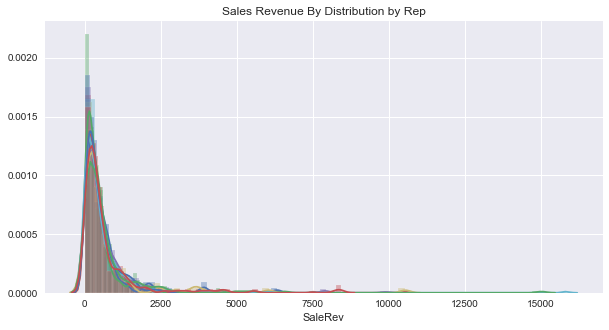

In [197]:
fig, ax = plt.subplots(figsize=(10,5))
for k,v in reps.items():
    sns.distplot(v,label=v)

plt.title('Sales Revenue By Distribution by Rep')
print('Distributions appear roughly equal and there appears to be outliers')

#### Initial Observations:
Datatype is numeric in this 2155 order sample.

There are 9 employees in this company associated with sales information

The avarage revenue generated by a sales representative is $629.00. 

Initial visual inspection indicates roughly uniform distribution in sales revenue, more than half of the sales representatives achieve the average.  Additional testing will demonstrate if it is significant.

Since we are comparing multiple discounts to inspect it's impact on quantity ordered an AVNOVA test will be run:
Assumptions for ANOVA Testing: 

1) No significant outliers 
    Upon a quick visual inspection, there appears to be some outliers that could be removed

2) Equal variance
    


3) Normality (if n>15)
      Not required for samples greater than 15

### Assumption 1: Outliers

In [198]:
for rep, rep_data in reps.items():
    idx_outs = fn.find_outliers_Z(rep_data)
    print(f'Found {idx_outs.sum()} outliers in Employee # {rep}')
    reps[rep] = rep_data[~idx_outs]
print('\n All of these outliers were removed')



Found 3 outliers in Employee # 5
Found 3 outliers in Employee # 6
Found 7 outliers in Employee # 4
Found 4 outliers in Employee # 3
Found 2 outliers in Employee # 9
Found 4 outliers in Employee # 1
Found 5 outliers in Employee # 8
Found 5 outliers in Employee # 2
Found 5 outliers in Employee # 7

 All of these outliers were removed


Distributions appear roughly equal and outliers are visibly removed in comparisson with other visual


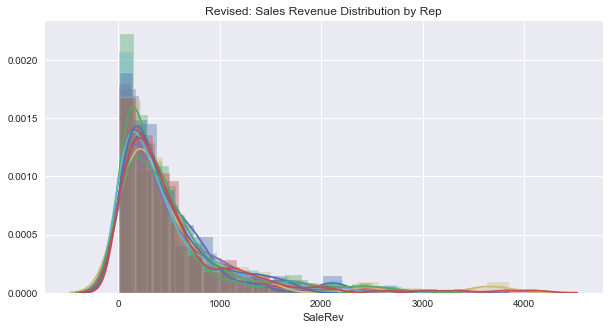

In [199]:
fig, ax = plt.subplots(figsize=(10,5))
for k,v in reps.items():
    sns.distplot(v,label=v)

plt.title('Revised: Sales Revenue Distribution by Rep')
print('Distributions appear roughly equal and outliers are visibly removed in comparisson with other visual')

###  Asumption 2: Equal Variance

Results are NOT equal variance for this group

In [200]:
#from functions import test_equal_variance
import scipy.stats as stats

In [201]:
datas = []
for k,v in reps.items():
    datas.append(v)
    

In [202]:
stat,p = stats.levene(*datas)
print(f'Lavene test for equal variance results are {round(p,4)}')
sig = 'do NOT' if p < .05 else 'DO'

print(f'The groups {sig} have equal variance')
      
          

Lavene test for equal variance results are 0.0143
The groups do NOT have equal variance


### Assumption 3:  Normality
The lengths of these samples are >15 so normality criteria is met.

In [203]:
n = []

for rep,samples in reps.items():
    print(f'There are {len(samples)} samples in the data set for Employee #{rep}.')
    n.append(len(samples)>15)
if all(n):
    print('\nAll samples are >15: Normality Assumption Criterion is met.')
    





There are 114 samples in the data set for Employee #5.
There are 165 samples in the data set for Employee #6.
There are 413 samples in the data set for Employee #4.
There are 317 samples in the data set for Employee #3.
There are 105 samples in the data set for Employee #9.
There are 341 samples in the data set for Employee #1.
There are 255 samples in the data set for Employee #8.
There are 236 samples in the data set for Employee #2.
There are 171 samples in the data set for Employee #7.

All samples are >15: Normality Assumption Criterion is met.


In [204]:
stat, p = stats.kruskal(*datas)
print(f"Kruskal test p value: {round(p,4)}")

Kruskal test p value: 0.2968


In [205]:
stat, p = stats.f_oneway(*datas)
print(stat,p)

2.180626766904163 0.026222185205141618


In [206]:
clean_data = fn.prep_data_for_tukeys(reps)
clean_data

,data,group
0,168.000,5
1,98.000,5
2,174.000,5
17,45.900,5
18,342.720,5
...,...,...
2077,390.000,7
2103,52.350,7
2104,386.400,7
2105,490.000,7


### Hypothesis 3: A Clean Visualization:

Text(0.5, 1.0, 'Average Revenue Generated by Sales Representative')

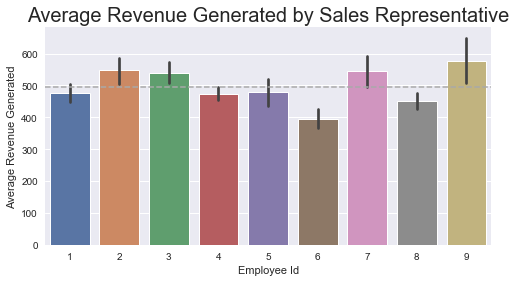

In [207]:
f, ax = plt.subplots(figsize=(8,4))
sns.set(style="whitegrid")
sns.barplot(data=clean_data, x='group', y='data', ci=68)
plt.xlabel('Employee Id')
plt.ylabel('Average Revenue Generated')
plt.axhline(clean_data['data'].mean(), linestyle="--", color='darkgray')

plt.title('Average Revenue Generated by Sales Representative', fontsize=20)


Observation:
The plot above is misleading since it goes off of means it skews the data.  Further testing indicates there are no statistical differences between representatives in terms of revenue generated over this time span.  The subsequent plot reveals a more accurate depiction of what testing demonstrates.

Average revenue across all sales representatives: $494.72


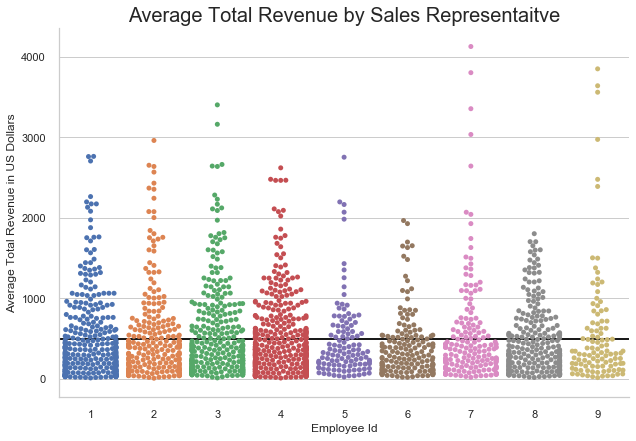

In [208]:
mu = clean_data['data'].mean()

sns.catplot(data=clean_data, x='group', y='data', 
            kind='swarm', height=6, aspect=1.5)
formatter = ticker.FormatStrFormatter('$%1.2f')
plt.axhline(mu, color='k', linestyle="-", lw=2)
plt.xlabel('Employee Id')
plt.ylabel('Average Total Revenue in US Dollars')
plt.title('Average Total Revenue by Sales Representaitve', fontsize=20)
print(f'Average revenue across all sales representatives: ${round(mu,2)}')

In [209]:
#datacleaning for additional testing:
clean_data['data'] = clean_data['data'].astype(float)
clean_data['group'] = clean_data['group'].astype(str)

In [210]:
clean_data

,data,group
0,168.000,5
1,98.000,5
2,174.000,5
17,45.900,5
18,342.720,5
...,...,...
2077,390.000,7
2103,52.350,7
2104,386.400,7
2105,490.000,7


## The table below illustrates to accept the null hypothesis.

In [211]:
tukeys = sms.stats.multicomp.pairwise_tukeyhsd(clean_data['data'], clean_data['group'])
tukeys.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,70.6795,0.7896,-67.9146,209.2736,False
1,3,62.1979,0.8328,-65.5036,189.8995,False
1,4,-2.0207,0.9,-121.7839,117.7426,False
1,5,2.7041,0.9,-174.3746,179.7827,False
1,6,-81.4678,0.7616,-236.6872,73.7517,False
1,7,68.5247,0.9,-84.8486,221.8981,False
1,8,-24.7293,0.9,-160.2376,110.779,False
1,9,101.7408,0.7013,-80.9369,284.4186,False
2,3,-8.4815,0.9,-149.2052,132.2421,False
2,4,-72.7002,0.725,-206.2617,60.8614,False


### Effect Size Testing:

In [212]:
tukeyrepdf = fn.tukey_df(tukeys)

In [213]:
tukeyrepdf

,group1,group2,meandiff,p-adj,lower,upper,reject
0,1,2,70.6795,0.7896,-67.9146,209.2736,False
1,1,3,62.1979,0.8328,-65.5036,189.8995,False
2,1,4,-2.0207,0.9000,-121.7839,117.7426,False
3,1,5,2.7041,0.9000,-174.3746,179.7827,False
4,1,6,-81.4678,0.7616,-236.6872,73.7517,False
5,1,7,68.5247,0.9000,-84.8486,221.8981,False
6,1,8,-24.7293,0.9000,-160.2376,110.7790,False
7,1,9,101.7408,0.7013,-80.9369,284.4186,False
8,2,3,-8.4815,0.9000,-149.2052,132.2421,False
9,2,4,-72.7002,0.7250,-206.2617,60.8614,False


### Hypothesis 3 Results Table:

In [214]:
fn.mult_Cohn_d(tukeyrepdf, reps)

,g1,g2,padj,d
0,1,2,0.7896,-0.130744
1,1,3,0.8328,-0.114624
2,1,4,0.9000,0.004144
3,1,5,0.9000,-0.005335
4,1,6,0.7616,0.170314
5,1,7,0.9000,-0.120978
6,1,8,0.9000,0.052428
7,1,9,0.7013,-0.176757
8,2,3,0.9000,0.014775
9,2,4,0.7250,0.143003


### Findings and recommendations: 


#### Findings:
Both parametric and non parametric tests were conducted, despite indications for non-parametric tests as the dataset(s) did not meet the assupmtion of equal variance. A visual inspection after outlier removal suggested there could be significant variance in the mean and the parametric was run for comparison.  The parametric test indicated that the null hypothesis could be rejected.  However, post-hoc testing validated the efficacy of the non-parametric test to **accept the null hypothesis**, with the smallest probability that the outcome was due to chance was well over the accepted rate of .05. 

The Hypothesis 3 Results Table above provides details on how each representative compares with one another and is itemized by the adjusted p values and d is the result of a Cohen D illustrating the effect size of each comparison.


#### Recommendation:    
If there is no statistical difference, and effect size is small at best, best practices can still be shared by those who have a higher average revenue, examples 2,3 and 9 still have higher than average sales.
    
Perhaps a little healthy, insentivised competition might spur increased revenues if not by one, by many.  Also, building on knowledge of smaller discounts yielding larger quantities, sales team could increase revenue by being conservative with discount rates.
   
    

# HYPOTHESIS 4

>  ***Where are the customers from that spend the most money?  Do some regions generate statistically significantly more revenue than others?***

$H0$: Customers spend equal amounts regardless of region.

$H1$: Region has an effect on total amount spent.


    

#### Importing and inspecting data from  OrderDetail and Order

These table includes information on:

    1) Sales total information 
    2) Regions where orders shipped to indicating the location of customers

In [215]:
cur.execute("""SELECT 
                ShipRegion, 
                OrderID, 
                ProductID, 
                UnitPrice,
                Quantity, 
                Discount
                FROM `Order` AS o
                JOIN OrderDetail AS od
                on o.ID = od.OrderId ;""")
dfreg = pd.DataFrame(cur.fetchall(), columns=[x[0] for x in cur.description])
dfreg.head()

,ShipRegion,OrderId,ProductId,UnitPrice,Quantity,Discount
0,Western Europe,10248,11,14.0,12,0.0
1,Western Europe,10248,42,9.8,10,0.0
2,Western Europe,10248,72,34.8,5,0.0
3,Western Europe,10249,14,18.6,9,0.0
4,Western Europe,10249,51,42.4,40,0.0


In [216]:
dfreg['Amount_Spent'] = ((dfreg['UnitPrice'])*(1 - dfreg['Discount']))*dfreg['Quantity']

### Hypothesis 4 Preliminary Visualizations:

The average total spend is $587.37
The distribution indicates there may be outliers.


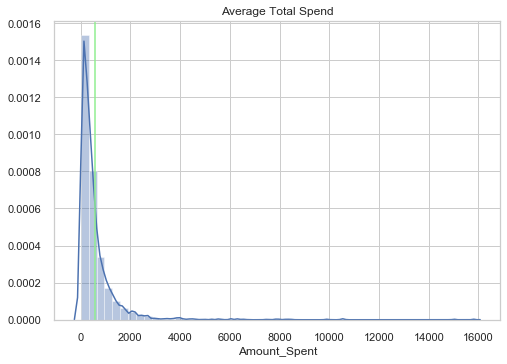

In [217]:
fig, ax = plt.subplots()
spend_mu = dfreg['Amount_Spent'].mean()
sns.distplot(dfreg['Amount_Spent'], ax=ax)
plt.axvline(spend_mu, color='lightgreen')
plt.title('Average Total Spend')
print(f'The average total spend is ${round(spend_mu,2)}')
print(f'The distribution indicates there may be outliers.')

In [218]:
regs = {}
for reg in dfreg['ShipRegion'].unique():
    regs[reg] = dfreg.groupby('ShipRegion').get_group(reg)['Amount_Spent']


In [219]:
regions = list(dfreg['ShipRegion'].unique())
regions
print(f'There are {len(regions)} regions, they are {regions}.')

There are 9 regions, they are ['Western Europe', 'South America', 'Central America', 'North America', 'Northern Europe', 'Scandinavia', 'Southern Europe', 'British Isles', 'Eastern Europe'].


Distributions appear roughly equal, although there appears to be outliers


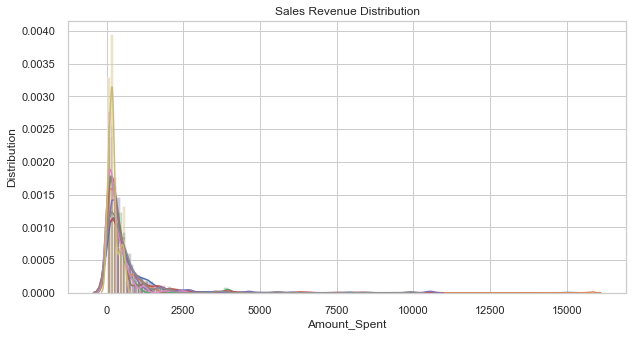

In [220]:
fig, ax = plt.subplots(figsize=(10,5))
for k,v in regs.items():
    sns.distplot(v,label=v)


plt.title('Sales Revenue Distribution')
plt.ylabel('Distribution')
print('Distributions appear roughly equal, although there appears to be outliers')

In [221]:
@interact
def plt_discounts(d=regions):
    sns.distplot(dfreg.groupby('ShipRegion').get_group(d)['Amount_Spent'])
    plt.axvline(spend_mu, color='purple')
    plt.gca()

interactive(children=(Dropdown(description='d', options=('Western Europe', 'South America', 'Central America',…

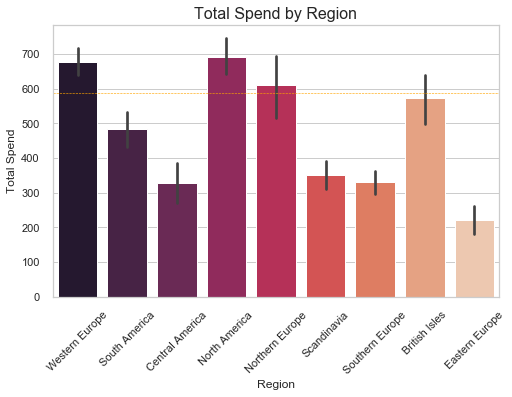

In [222]:
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(data=dfreg, x='ShipRegion', y='Amount_Spent', ci=68, palette="rocket", ax=ax)
plt.title('Total Spend by Region', fontsize=16)
plt.axhline(spend_mu,linestyle="--", color='orange', linewidth=.6 )
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.ylabel('Total Spend')
plt.show()

#### Hypothesis 4 Initial Observations:
Datatype is numeric in this 2155 order sample.

There are 9 regions in reflected in this dataset

The avarage of total spent is $587.37.

Initial visual inspection indicates skewed, but roughly uniform distribution in total sales, more than half of the sales representatives achieve the average. Additional testing will demonstrate if it is significant.

Since we are comparing multiple regions to inspect it's impact on quantity ordered an AVNOVA test will be run: Assumptions for ANOVA Testing:

1) Upon a quick visual inspection, there appears to be some outliers that could be removed

2) Equal variance

3) Normality (if n>15) Not required for samples greater than 15

### Hypothesis 4 Assumption 1: Outlier 
Outliers were identified and removed via z-score testing.  Details are below:

In [223]:
regs = {}
for reg in dfreg['ShipRegion'].unique():
    regs[reg] = dfreg.groupby('ShipRegion').get_group(reg)['Amount_Spent']


In [224]:
for reg, reg_data in regs.items():
    idx_outs = fn.find_outliers_Z(reg_data)
    print(f'Found {idx_outs.sum()} outliers in the {reg}')
    regs[reg] = reg_data[~idx_outs]
print('\n All of these outliers were removed')

Found 11 outliers in the Western Europe
Found 2 outliers in the South America
Found 1 outliers in the Central America
Found 9 outliers in the North America
Found 2 outliers in the Northern Europe
Found 1 outliers in the Scandinavia
Found 3 outliers in the Southern Europe
Found 4 outliers in the British Isles
Found 0 outliers in the Eastern Europe

 All of these outliers were removed


### Hypothesis 4 Assumption 2: Equal Variance

In [225]:
data = []
labels = []
for k,v in regs.items():
    data.append(v)
    labels.append(k)

In [226]:
stat,p = stats.levene(*data, center = 'median')
print(f'Lavene test for equal variance results are {round(p,4)}')
sig = 'do NOT' if p < .05 else 'DO'

print(f'The groups {sig} have equal variance')
      

Lavene test for equal variance results are 0.0
The groups do NOT have equal variance


### Hypothesis 4 Assumption 3: Normality

In [227]:
n =[]
for reg, samples in regs.items():
    print(f'There are {len(samples)} samples in the data set for Regions #{reg}.')
    n.append(len(samples)>15)
if all(n):
    print('\nAll samples are >15: Normality Assumption Criterion is met.')

There are 734 samples in the data set for Regions #Western Europe.
There are 353 samples in the data set for Regions #South America.
There are 71 samples in the data set for Regions #Central America.
There are 418 samples in the data set for Regions #North America.
There are 141 samples in the data set for Regions #Northern Europe.
There are 69 samples in the data set for Regions #Scandinavia.
There are 134 samples in the data set for Regions #Southern Europe.
There are 186 samples in the data set for Regions #British Isles.
There are 16 samples in the data set for Regions #Eastern Europe.

All samples are >15: Normality Assumption Criterion is met.


#### Using non-parametric Kruskal since the data set was not of equal variance:

In [228]:
stat, p = stats.kruskal(*data)
print(f"Kruskal test p value: {round(p,6)}")

Kruskal test p value: 0.0


In [229]:
cregs = fn.prep_data_for_tukeys(regs)  
cregs

,data,group
0,168.0,Western Europe
1,98.0,Western Europe
2,174.0,Western Europe
3,167.4,Western Europe
4,1696.0,Western Europe
...,...,...
1933,54.0,Eastern Europe
1934,199.5,Eastern Europe
1935,200.0,Eastern Europe
1936,232.5,Eastern Europe


In [230]:
mu = cregs['data'].mean()
mu

500.12534142318566

In [231]:
cregs['data']=cregs['data'].astype(float)
cregs['group']=cregs['group'].astype(str)

In [232]:
tukeyr = sms.stats.multicomp.pairwise_tukeyhsd(cregs['data'],cregs['group'])
tukeyr.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
British Isles,Central America,-185.8522,0.2271,-415.6671,43.9628,False
British Isles,Eastern Europe,-241.5782,0.6901,-670.7752,187.6188,False
British Isles,North America,108.0077,0.3368,-37.1939,253.2093,False
British Isles,Northern Europe,48.1291,0.9,-135.8232,232.0814,False
British Isles,Scandinavia,-137.1482,0.6379,-369.3612,95.0647,False
British Isles,South America,-38.1848,0.9,-187.4464,111.0767,False
British Isles,Southern Europe,-172.9738,0.0946,-359.6391,13.6914,False
British Isles,Western Europe,124.6055,0.0989,-10.6288,259.8398,False
Central America,Eastern Europe,-55.726,0.9,-511.6242,400.1721,False
Central America,North America,293.8599,0.001,82.3968,505.3229,True


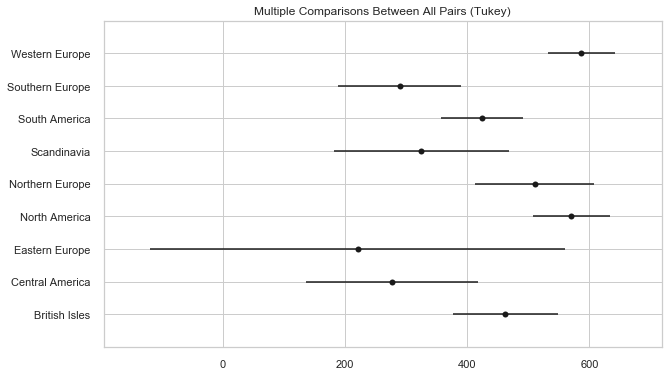

In [233]:
tukeyr.plot_simultaneous();

** Noting that the sample size of Eastern Europe is relatively small and the confidence interval is much greater to accomodate for it, possibly skewing the results of the table below.

In [234]:
tukeyr_df = fn.tukey_df(tukeyr)

In [235]:
tukeyr_false = tukeyr_df[tukeyr_df['reject']==False]
tukeyr_false

,group1,group2,meandiff,p-adj,lower,upper,reject
0,British Isles,Central America,-185.8522,0.2271,-415.6671,43.9628,False
1,British Isles,Eastern Europe,-241.5782,0.6901,-670.7752,187.6188,False
2,British Isles,North America,108.0077,0.3368,-37.1939,253.2093,False
3,British Isles,Northern Europe,48.1291,0.9000,-135.8232,232.0814,False
4,British Isles,Scandinavia,-137.1482,0.6379,-369.3612,95.0647,False
5,British Isles,South America,-38.1848,0.9000,-187.4464,111.0767,False
6,British Isles,Southern Europe,-172.9738,0.0946,-359.6391,13.6914,False
7,British Isles,Western Europe,124.6055,0.0989,-10.6288,259.8398,False
8,Central America,Eastern Europe,-55.7260,0.9000,-511.6242,400.1721,False
10,Central America,Northern Europe,233.9812,0.0623,-5.7511,473.7136,False


In [236]:
tukeyr_trues = tukeyr_df[tukeyr_df['reject']==True]
tukeyr_trues

,group1,group2,meandiff,p-adj,lower,upper,reject
9,Central America,North America,293.8599,0.0010,82.3968,505.3229,True
14,Central America,Western Europe,310.4577,0.0010,105.7104,515.2050,True
22,North America,Scandinavia,-245.1559,0.0115,-459.2227,-31.0892,True
23,North America,South America,-146.1925,0.0045,-265.2754,-27.1097,True
24,North America,Southern Europe,-280.9815,0.0010,-444.5224,-117.4406,True
28,Northern Europe,Southern Europe,-221.1029,0.0164,-419.8505,-22.3554,True
32,Scandinavia,Western Europe,261.7538,0.0030,54.3185,469.1890,True
34,South America,Western Europe,162.7904,0.0010,56.0873,269.4934,True
35,Southern Europe,Western Europe,297.5794,0.0010,142.8200,452.3387,True


In [237]:
mult_Cohn_d(tukeyr_trues, regs)

,g1,g2,padj,d
0,Central America,North America,0.0010,-0.485386
1,Central America,Western Europe,0.0010,-0.548229
2,North America,Scandinavia,0.0115,0.402484
3,North America,South America,0.0045,0.262021
4,North America,Southern Europe,0.0010,0.485062
5,Northern Europe,Southern Europe,0.0164,0.481990
6,Scandinavia,Western Europe,0.0030,-0.460358
7,South America,Western Europe,0.0010,-0.300535
8,Southern Europe,Western Europe,0.0010,-0.539438


In [238]:
for reg, rev in regs.items():
    print(f'The average revenue for {reg} is ${round(rev.mean(),2)}')

The average revenue for Western Europe is $586.93
The average revenue for South America is $424.14
The average revenue for Central America is $276.47
The average revenue for North America is $570.33
The average revenue for Northern Europe is $510.45
The average revenue for Scandinavia is $325.18
The average revenue for Southern Europe is $289.35
The average revenue for British Isles is $462.33
The average revenue for Eastern Europe is $220.75


### Hypothesis 4 Observations and Recommendations:

#### Obeservations 
The average spend for this dataset accross all regions was $500.

Regional averages were found to be what is reported in the table below: 

Region | Average Revenue
 -- | --|
Western Europe | `$586.93`
North America | `$570.33`
Northern Europe | `$510.45`
British Isles | `$462.33`
South America | `$424.14`
Scandinavia | `$325.18`
Southern Europe | `$289.35`
Central America | `$276.47`
Eastern Europe | `$220.75

For each group, the assumption for equal variance was not met and a Kruksal test was conducted.  The p value for the nonparametric kruskal test was singificant, which can reject the null hypothesis that all regions spend the same amounts with a 5% degree of error that this is due to chance.

Orders shipped to Western Europe, and North America and Northern Europe generated the highest amount of revenue, statistically these regions are equal:  

Region 1 | Region 2 |  MeanDiff | Adj P | Reject Null
 -- | -- | --| --| --|
North America | Northern Europe	| -59.8786	| 0.9000 | False
North America | Western Europe | 16.5978 | 0.9000	|	False
Northern Europe	| Western Europe | 76.4764 | 0.7992	| False


For bottom performers that had enough data:

Region 1 | Region 2 | Adj P 
 -- | -- | --|
South America |	Southern Europe	| 0.2306		

#### Recommendations:
Explore best practices from regions that are top performers.  
Market analysis for regions that need to be developed. 
Leverage knowledge gained regarding categories and discounts.


In [239]:
indexr = list(cregs.groupby('group').mean().sort_values('data', ascending=False).index)
indexr

['Western Europe',
 'North America',
 'Northern Europe',
 'British Isles',
 'South America',
 'Scandinavia',
 'Southern Europe',
 'Central America',
 'Eastern Europe']

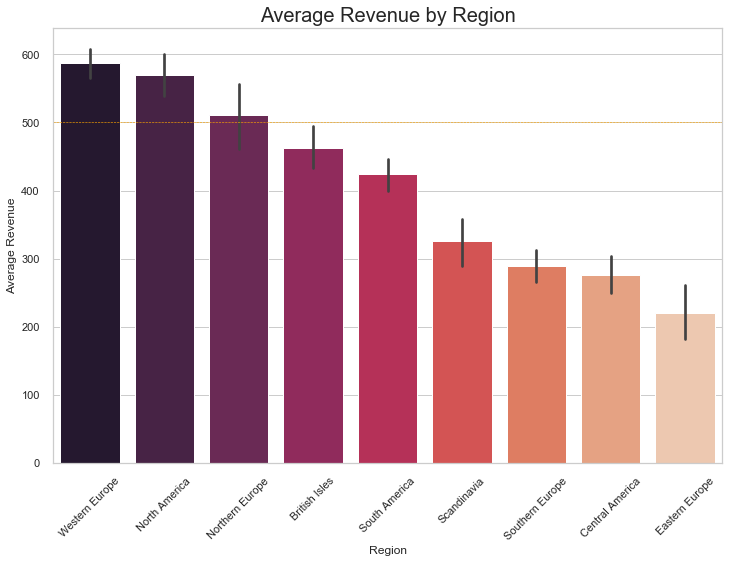

In [240]:
avspend = cregs['data'].mean()
avspend
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=cregs, x='group', y='data', ci=68,order=indexr, palette="rocket", ax=ax)
plt.title('Average Revenue by Region', fontsize=20)
plt.axhline(avspend,linestyle="--", color='orange', linewidth=.6 )
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.ylabel('Average Revenue')
plt.show()

# In Closing:

Since the data provided did not include purchase prices of merchandise, ways were examined to maximize revenues.
The datasets were all multi group comparisons and none of the groups met all the assupmtions for parametric testing.  All groups called for Kruskal-Wallis and post-hoc testing detailed in this notebook.

It was discovered through hypothesis testing and data analysis, various ways to achieve this through: 
    Minimizing discounts
    Broadening Revenue Generating Categories
    **add alllll the recommendations)
    
In addition, future analysis and testeing could provide insight to: 
    Develop Regional Markets
    Develop Sales Staff
    
   